In [1]:
## source: Qutiles-3head.ipynb from pytorch-temp

In [2]:
def get_cuda_summary(memory=False):
    import torch
    
    if torch.cuda.is_available():
        print('CUDA device = ', torch.cuda.get_device_name())
        print('Available number of devices = ', torch.cuda.device_count())
        print('Device numbers              = ', list(range(torch.cuda.device_count())))
        print('Current device              = ', torch.cuda.current_device())
        if memory:
            print(torch.cuda.memory_summary())
    else:
        print('cuda is not available')
    

In [3]:
import torch
get_cuda_summary()
torch.cuda.set_device(1)
#do not execute this if you fit auto-pytorch model

CUDA device =  Tesla V100-SXM2-32GB
Available number of devices =  2
Device numbers              =  [0, 1]
Current device              =  0


## Data Generation
* source : COLAB `robust_multihead-3quantiles.ipynb` 
  - data point = 10000개, 분산이 증가하는 sin 함수
  - `(x,y)` : 표준화 전, `(train_x, train_y)` : 표준화 후

In [4]:
import numpy as np

N = 10000

train_x = np.random.normal(0,1,(N,)) # 표준화 된 값
x = 3*train_x+1

# Cauchy distributed error
s = np.random.standard_cauchy(N)/2

# Laplace distribution
s = np.random.laplace(size=N)

# t-distribution
s = np.random.standard_t(df = 3, size=N)

# Normal distribution
s = np.random.normal(0, 1, N)


#xmean = np.mean(x)
#xsd = np.std(x)

y = train_x/3*s*4 + np.sin(train_x/3*13)*4 + 10

ymean = np.mean(y)
ysd = np.std(y)

xmean = np.mean(x)
xsd = np.std(x)
train_y = (y-ymean)/ysd

In [5]:
#from data1x1ycyclicA import dat, data

#train_x = dat['x_scaled']
#train_y = dat['y_scaled']

In [6]:
%matplotlib inline

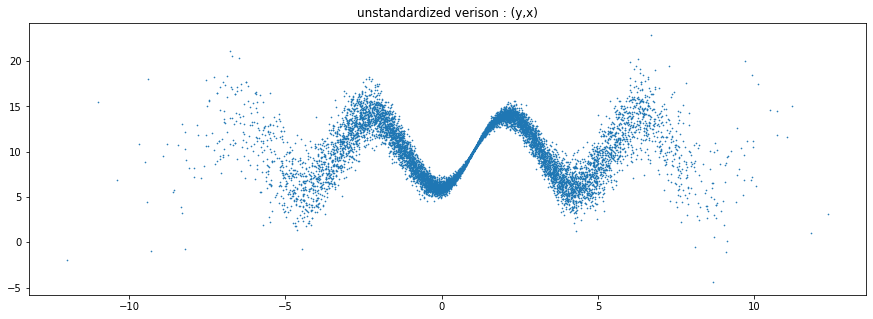

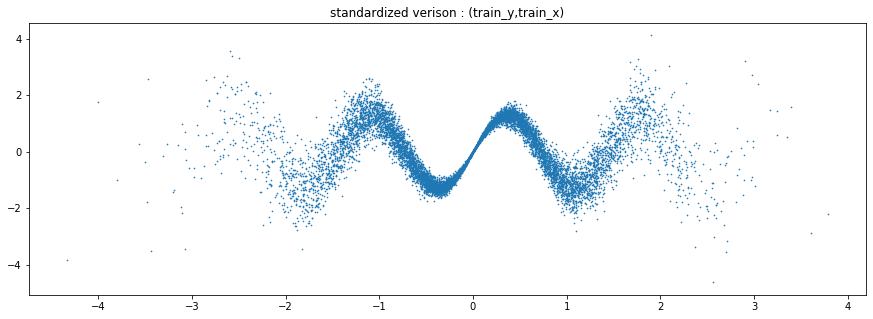

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.scatter(x, y, s=0.4)
plt.title('unstandardized verison : (y,x)')
plt.show()

plt.figure(figsize=(15,5))
plt.scatter(train_x, train_y, s=0.4)
plt.title('standardized verison : (train_y,train_x)')
plt.show()

In [8]:
import pandas as pd

import torch
from torch import nn
import os
import matplotlib.pyplot as plt

#os.environ['KMP_DUPLICATE_LIB_OK']='True'

# data = pd.read_csv('/content/02_Linear_Regression_Model_Data.csv')
# Avoid copy data, just refer
train_x_tr = torch.from_numpy(train_x.reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
train_y_tr = torch.from_numpy(train_y.reshape([-1,1])).float()#torch.from_numpy(data['y'].values[:1000]).unsqueeze(dim=1).float()


# Three-headed quantile regression model 
## `modelA` : output.shape = (:,3) array

In [9]:
# 3-headed output
# modification to MyModel
#    return output1, output2, output3 -> return self.net(x)  # torch.nn.Linear(30,3)
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel,self).__init__()
        #self.linear_yq1_output = torch.nn.Linear(30,1)
        #self.linear_yq2_output = torch.nn.Linear(30,1)
        #self.linear_yq3_output = torch.nn.Linear(30,1)

        self.net = torch.nn.Sequential(
        torch.nn.Linear(1, 30),
        torch.nn.LeakyReLU(),
        #torch.nn.Tanh(),
        
        torch.nn.Linear(30, 30),
        torch.nn.LeakyReLU(),
            
        torch.nn.Linear(30,3)

        #torch.nn.Tanh(),
        )

    def forward(self,x):
        return self.net(x)
    
modelA = MyModel()
modelA = modelA.cuda()

optimizer = torch.optim.Adam(params=modelA.parameters(), lr=0.001)

def criterion(input, target):
    ## Other Losses
    # Normal loss
    #loss = (((input[0] - target)/torch.exp(input[1]))**2+input[1]).mean()
    # Laplace loss
    #loss = (torch.abs((input[0] - target)/torch.exp(input[1]))+input[1]).mean()
    # t-distribution loss
    #nu = 3
    #loss = ((nu + 1)/2*torch.log(1+((input[0] - target)/torch.exp(input[1]))**2/nu)+input[1]).mean()
    # print(input, target)

    ## Quanile Loss
    q1 = 0.05
    q2 = 0.5
    q3 = 0.95
    

    ## Keras quantile loss, https://www.evergreeninnovations.co/blog-quantile-loss-function-for-machine-learning/    
    #e = y_p-y    
    #return tf.keras.backend.mean(tf.keras.backend.maximum(q*e, (q-1)*e))

    ## Quantile Loss
    ## for q1, q2, q3
    #print(input.shape)
    #print(input[:,0:1].shape)
    #print(target.shape)
    e1 = input[:,0:1] - target # !!! if input[:,0]  -> shape = (1000,)
    e2 = input[:,1:2] - target
    e3 = input[:,2:3] - target
    eq1 = torch.max(q1*e1, (q1-1)*e1)
    eq2 = torch.max(q2*e2, (q2-1)*e2)
    eq3 = torch.max(q3*e3, (q3-1)*e3)
    
    #eq1 = torch.max(0.05*e1, (0.05-1)*e1)
    #eq2 = torch.max(0.5*e2, (0.5-1)*e2)
    #eq3 = torch.max(0.95*e3, (0.95-1)*e3)

    loss = (eq1 + eq2 + eq3).mean()

    return loss
    
train_x_tr = train_x_tr.cuda()    
train_y_tr = train_y_tr.cuda()

for step in range(3000):
    #yq1, yq2, yq3 = model(x)
    #loss = criterion(input=(yq1, yq2, yq3), target=y)
    yqs = modelA(train_x_tr)
    loss = criterion(input=yqs, target =train_y_tr)
    #print(yqs.shape, train_y_tr.shape)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step+1) % 1000 == 0:
        """
        Show your intermediate results
        """
        print('epoch {} loss={:.4}'.format(step+1, loss.data.item()))
        pass

epoch 1000 loss=0.2274
epoch 2000 loss=0.2145
epoch 3000 loss=0.2115


In [10]:
train_y_tr

tensor([[-0.3957],
        [ 1.2270],
        [ 1.0565],
        ...,
        [ 1.1747],
        [ 0.9401],
        [ 0.5533]], device='cuda:1')

In [11]:
modelA(train_x_tr)

tensor([[-0.3558, -0.4020, -0.4434],
        [ 1.5448,  1.2751,  1.0002],
        [ 1.5317,  1.2722,  1.0219],
        ...,
        [ 1.4456,  1.2046,  1.0521],
        [ 2.0218,  0.0413, -2.3129],
        [ 1.2691,  0.8930,  0.4258]], device='cuda:1', grad_fn=<AddmmBackward>)

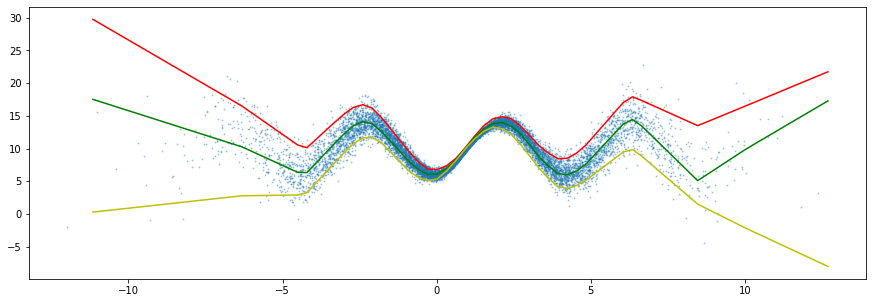

In [12]:
x_pred = torch.from_numpy(np.arange(-4,4,0.1).reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
y_pred = modelA(x_pred.cuda())

x_pred2 = xsd*x_pred+xmean
y_pred2 = ysd*y_pred+ymean

yqs = y_pred2.detach().cpu().numpy()

plt.figure(figsize=(15,5))

plt.scatter(x, y, s=1, alpha=0.3)

plt.plot(x_pred2.detach().cpu().numpy(), yqs[:,0], c='r')
plt.plot(x_pred2.detach().cpu().numpy(), yqs[:,1], c='g')
plt.plot(x_pred2.detach().cpu().numpy(), yqs[:,2], c='y')



# Three-headed quantile regression model 
## `modelB` : output.shape = tuple with 3x (:,1) array

In [13]:

class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel,self).__init__()
        self.linear_yq1_output = torch.nn.Linear(30,1)
        self.linear_yq2_output = torch.nn.Linear(30,1)
        self.linear_yq3_output = torch.nn.Linear(30,1)
        #self.linear_variance_output = torch.nn.Linear(30,1)

        self.net = torch.nn.Sequential(
        torch.nn.Linear(1, 30),
        torch.nn.LeakyReLU(),
        #torch.nn.Tanh(),
        
        torch.nn.Linear(30, 30),
        torch.nn.LeakyReLU(),

        #torch.nn.Tanh(),
        )

    def forward(self,x):
        x = self.net(x)
        yq1 = self.linear_yq1_output(x)
        yq2 = self.linear_yq2_output(x)
        yq3 = self.linear_yq3_output(x)
        
        #variance = self.linear_variance_output(x)
        #print(yqs)
        return yq1, yq2, yq3

modelB = MyModel()
modelB = modelB.cuda()

optimizer = torch.optim.Adam(params=modelB.parameters(), lr=0.001)

def criterion(input, target):
    ## Other Losses
    # Normal loss
    #loss = (((input[0] - target)/torch.exp(input[1]))**2+input[1]).mean()
    # Laplace loss
    #loss = (torch.abs((input[0] - target)/torch.exp(input[1]))+input[1]).mean()
    # t-distribution loss
    #nu = 3
    #loss = ((nu + 1)/2*torch.log(1+((input[0] - target)/torch.exp(input[1]))**2/nu)+input[1]).mean()
    # print(input, target)

    ## Quanile Loss
    q1 = 0.05
    q2 = 0.5
    q3 = 0.95

    ## Keras quantile loss, https://www.evergreeninnovations.co/blog-quantile-loss-function-for-machine-learning/    
    #e = y_p-y    
    #return tf.keras.backend.mean(tf.keras.backend.maximum(q*e, (q-1)*e))

    ## Quantile Loss
    ## for q1, q2, q3
    e1 = input[0] - target
    e2 = input[1] - target
    e3 = input[2] - target
    eq1 = torch.max(q1*e1, (q1-1)*e1)
    eq2 = torch.max(q2*e2, (q2-1)*e2)
    eq3 = torch.max(q3*e3, (q3-1)*e3)

    loss = (eq1 + eq2 + eq3).mean()

    return loss
    
#x = x.cuda()    
#y = y.cuda()
for step in range(5000):
    yq1, yq2, yq3 = modelB(train_x_tr)
    loss = criterion(input=(yq1, yq2, yq3), target=train_y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step+1) % 1000 == 0:
        """
        Show your intermediate results
        """
        print('epoch {} loss={:.4}'.format(step+1, loss.data.item()))
        pass
    
    

epoch 1000 loss=0.2145
epoch 2000 loss=0.2085
epoch 3000 loss=0.2073
epoch 4000 loss=0.2072
epoch 5000 loss=0.2071


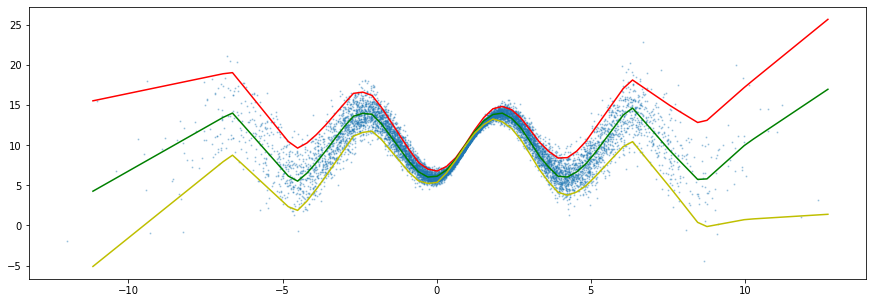

In [14]:
x_pred = torch.from_numpy(np.arange(-4,4,0.1).reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
x_pred = x_pred.cuda()
yq1, yq2, yq3 = modelB(x_pred)

x_pred2 = xsd*x_pred+xmean
yq1 = ysd*yq1+ymean
yq2 = ysd*yq2+ymean
yq3 = ysd*yq3+ymean

yq1 = yq1.detach().cpu().numpy()
yq2 = yq2.detach().cpu().numpy()
yq3 = yq3.detach().cpu().numpy()

plt.figure(figsize=(15,5))

plt.scatter(x, y, s=1, alpha=0.3)
plt.plot(x_pred2.detach().cpu().numpy(), yq1, c='r')
plt.plot(x_pred2.detach().cpu().numpy(), yq2, c='g')
plt.plot(x_pred2.detach().cpu().numpy(), yq3, c='y')


# Three-headed quantile regression model
## modelC : output.shape = tuple with 3x (:,1) array, using QuantileLoss

In [15]:
import torch
from torch import nn
from torch.nn.modules.loss import _Loss

class QuantileLoss(_Loss):
    # import numpy as np
    import warnings

    __constants__ = ['reduction']

    def __init__(self, size_average=None, reduce=None, reduction='mean', qs=(0.5,)):
            # size_average와 reduce는 앞으로 deprecated될 예정, reduction을 사용하라
            # reduction = 'mean' or 'sum' or 'none'
        super(QuantileLoss, self).__init__(size_average, reduce, reduction)
        if not(isinstance(qs, tuple)) and not(isinstance(qs, np.ndarray)):
            raise ValueError('qs must be either list or np.array')
        if isinstance(qs, tuple):
            qs = np.array(qs)
        if isinstance(qs, np.ndarray) and not (len(qs.shape) == 1):
            raise ValueError('qs must be shape of 1 dim')

        self.qs = qs

    def forward(self, input, target):
        # 위의 l1_loss에서 따옴
        # l1_loss(input, target, size_average=None, reduce=None, reduction='mean')
        reduction = self.reduction
        #if not torch.jit.is_scripting():  # 뭐 하는 곳인지 모름
        #    raise ValueError('QuantileLoss: torch.jit.is_scripting() not implemented')
        #    #tens_ops = (input, target)
        #    #if any([type(t) is not Tensor for t in tens_ops]) and has_torch_function(tens_ops):
        #    #    return handle_torch_function(
        #    #        l1_loss, tens_ops, input, target, size_average=size_average, reduce=reduce,
        #    #        reduction=reduction)
        if not (target.size() == input.size()):
            warnings.warn("Using a target size ({}) that is different to the input size ({}). "
                          "This will likely lead to incorrect results due to broadcasting. "
                          "Please ensure they have the same size.".format(target.size(), input.size()),
                          stacklevel=2)
            
        qs = torch.tensor(self.qs, dtype = input.dtype, requires_grad=False).to(input.device)
        #if target.requires_grad: # 아마 target이 고정되어 있는 경우 else:에서 빠른 처리가 가능한 듯.
        if True:
            e = target - input           
            # if dim of e and self.qs does not match, it will generate error.
            ret = torch.max(qs * e, (qs - 1) * e)
            #ret = torch.abs(input - target) # MAE 
        if reduction != 'none':
            ret = torch.mean(ret) if reduction == 'mean' else torch.sum(ret)
        else:
            raise ValueError('not(target.requires_grad): not yet implemented')
            #expanded_input, expanded_target = torch.broadcast_tensors(input, target)
            #ret = torch._C._nn.l1_loss(expanded_input, expanded_target, _Reduction.get_enum(reduction))
        return ret

ql = QuantileLoss(qs=(0.05, 0.5, 0.95))


In [16]:
# 3-headed output
# modification to MyModel
#    return output1, output2, output3 -> return self.net(x)  # torch.nn.Linear(30,3)
import warnings
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel,self).__init__()
        #self.linear_yq1_output = torch.nn.Linear(30,1)
        #self.linear_yq2_output = torch.nn.Linear(30,1)
        #self.linear_yq3_output = torch.nn.Linear(30,1)

        self.net = torch.nn.Sequential(
        torch.nn.Linear(1, 30),
        torch.nn.LeakyReLU(),
        #torch.nn.Tanh(),
        
        torch.nn.Linear(30, 30),
        torch.nn.LeakyReLU(),
            
        torch.nn.Linear(30,3)

        #torch.nn.Tanh(),
        )

    def forward(self,x):
        return self.net(x)
    
modelC = MyModel()
modelC = modelC.cuda()

optimizer = torch.optim.Adam(params=modelC.parameters(), lr=0.001)

    
train_x_tr = train_x_tr.cuda()    
train_y_tr = train_y_tr.cuda()

for step in range(3000):
    #yq1, yq2, yq3 = model(x)
    #loss = criterion(input=(yq1, yq2, yq3), target=y)
    yqs = modelC(train_x_tr)
    loss = ql(input=yqs, target =train_y_tr)
    #print(yqs.shape, train_y_tr.shape)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step+1) % 1000 == 0:
        """
        Show your intermediate results
        """
        print('epoch {} loss={:.4}'.format(step+1, loss.data.item()))
        pass

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/modules/module.py:532: UserWarning: Using a target size (torch.Size([10000, 1])) that is different to the input size (torch.Size([10000, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  result = self.forward(*input, **kwargs)


epoch 1000 loss=0.08027
epoch 2000 loss=0.07091
epoch 3000 loss=0.07009


In [17]:
## 각 nn.Linear(30,1)을 따로 initialization하는 것보다,
## nn.Linear(30,3)을 initialization 하는 것이 학습에 더 유리할 수도...

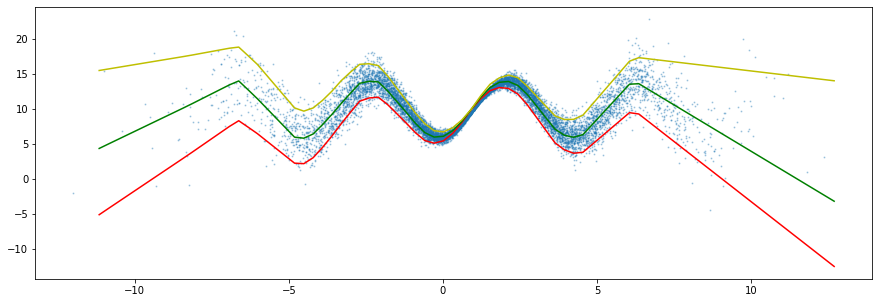

In [18]:
x_pred = torch.from_numpy(np.arange(-4,4,0.1).reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
y_pred = modelC(x_pred.cuda())

x_pred2 = xsd*x_pred+xmean
y_pred2 = ysd*y_pred+ymean

yqs = y_pred2.detach().cpu().numpy()

plt.figure(figsize=(15,5))

plt.scatter(x, y, s=1, alpha=0.3)

plt.plot(x_pred2.detach().cpu().numpy(), yqs[:,0], c='r')
plt.plot(x_pred2.detach().cpu().numpy(), yqs[:,1], c='g')
plt.plot(x_pred2.detach().cpu().numpy(), yqs[:,2], c='y')

In [19]:
torch.mean

In [20]:
a = torch.tensor([[1,2],[3,4]])

In [21]:
a[:,1:]

tensor([[2],
        [4]])

In [22]:
import torch
from torch import nn
from torch.nn.modules.loss import _Loss

class QinputLoss(_Loss):
    # import numpy as np
    import warnings

    __constants__ = ['reduction']

    def __init__(self, size_average=None, reduce=None, reduction='mean', ws=(0,1)):
            # size_average와 reduce는 앞으로 deprecated될 예정, reduction을 사용하라
            # reduction = 'mean' or 'sum' or 'none'
        super(QinputLoss, self).__init__(size_average, reduce, reduction)
        if not(isinstance(ws, tuple)) and not(isinstance(ws, np.ndarray)):
            raise ValueError('ws must be either list or np.array')
        if isinstance(ws, tuple):
            ws = np.array(ws)
        if isinstance(ws, np.ndarray) and not (len(ws.shape) == 1):
            raise ValueError('qs must be shape of 1 dim')

        self.ws = ws

    def forward(self, input, target):
        # 위의 l1_loss에서 따옴
        # l1_loss(input, target, size_average=None, reduce=None, reduction='mean')
        reduction = self.reduction
        #if not torch.jit.is_scripting():  # 뭐 하는 곳인지 모름
        #    raise ValueError('QuantileLoss: torch.jit.is_scripting() not implemented')
        #    #tens_ops = (input, target)
        #    #if any([type(t) is not Tensor for t in tens_ops]) and has_torch_function(tens_ops):
        #    #    return handle_torch_function(
        #    #        l1_loss, tens_ops, input, target, size_average=size_average, reduce=reduce,
        #    #        reduction=reduction)
        if not (target.size() == input.size()):
            warnings.warn("Using a target size ({}) that is different to the input size ({}). "
                          "This will likely lead to incorrect results due to broadcasting. "
                          "Please ensure they have the same size.".format(target.size(), input.size()),
                          stacklevel=2)
            
        ws = torch.tensor(self.ws, dtype = input.dtype, requires_grad=False).to(input.device)
        # ws : weights on quantile loss and weights on output 
        w_q = ws[0]
        w_input = ws[1:].reshape(1,-1)
        q = target[:,0:1]
        #if target.requires_grad: # 아마 target이 고정되어 있는 경우 else:에서 빠른 처리가 가능한 듯.
        if True:
            e_q = torch.abs(target[:,0]-input[:,0]) # q error, if w_q is 0, ignored
            e= target[:,1:] - input[:,1:] # target error
            
            # target[:,0:1] is q!
            ret = w_input*torch.max(q * e, (q - 1) * e)
            #ret = torch.abs(input - target) # MAE 
        if reduction != 'none':
            ret = torch.mean(ret) +torch.mean(w_q* e_q) if reduction == 'mean' else torch.sum(ret) + torch.sum(w_q*e_q)
        else:
            raise ValueError('not(target.requires_grad): not yet implemented')
            #expanded_input, expanded_target = torch.broadcast_tensors(input, target)
            #ret = torch._C._nn.l1_loss(expanded_input, expanded_target, _Reduction.get_enum(reduction))
        return ret 

qil = QinputLoss(ws=(0,1))


In [23]:
# 3-headed output
# modification to MyModel
#    return output1, output2, output3 -> return self.net(x)  # torch.nn.Linear(30,3)
import warnings
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel,self).__init__()
        #self.linear_yq1_output = torch.nn.Linear(30,1)
        #self.linear_yq2_output = torch.nn.Linear(30,1)
        #self.linear_yq3_output = torch.nn.Linear(30,1)

        self.net = torch.nn.Sequential(
        torch.nn.Linear(2, 50),
        torch.nn.LeakyReLU(),
        #torch.nn.Tanh(),
        
        torch.nn.Linear(50, 50),
        torch.nn.LeakyReLU(),
            
        torch.nn.Linear(50,2)

        #torch.nn.Tanh(),
        )

    def forward(self,x):
        return self.net(x)
    
modelD = MyModel()
modelD = modelD.cuda()

optimizer = torch.optim.Adam(params=modelD.parameters(), lr=0.001)

    
train_x_tr = train_x_tr.cuda()    
train_y_tr = train_y_tr.cuda()

for step in range(5000):
    qs = torch.tensor(np.random.uniform(0,1,train_x_tr.shape[0]), dtype=torch.float32).reshape(-1,1).cuda()
    
    output = modelD(torch.cat((qs,train_x_tr), dim=1))
    loss = qil(input=output, target =torch.cat((qs,train_y_tr), dim=1))
    #print(yqs.shape, train_y_tr.shape)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step+1) % 1000 == 0:
        """
        Show your intermediate results
        """
        print('epoch {} loss={:.4}'.format(step+1, loss.data.item()))
        pass

epoch 1000 loss=0.0996
epoch 2000 loss=0.09728
epoch 3000 loss=0.09875
epoch 4000 loss=0.09705
epoch 5000 loss=0.09761


In [24]:
modelD.eval()


x_pred = torch.from_numpy(np.arange(-4,4,0.1).reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
qs = torch.tensor(0.5*np.ones(x_pred.shape[0]), dtype=torch.float32).reshape(-1,1).cuda()

y_pred = modelD(torch.cat((qs,x_pred.cuda()), dim=1))


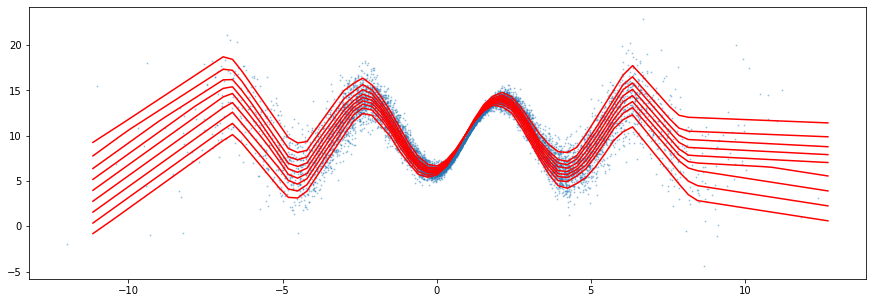

In [25]:
modelD.eval()
plt.figure(figsize=(15,5))
plt.scatter(x, y, s=1, alpha=0.3)

for q in range(1,10,1):


    x_pred = torch.from_numpy(np.arange(-4,4,0.1).reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
    qs = torch.tensor((q/10)*np.ones(x_pred.shape[0]), dtype=torch.float32).reshape(-1,1).cuda()

    output = modelD(torch.cat((qs,x_pred.cuda()), dim=1))

    y_pred = output[:, 1:]

    x_pred2 = xsd*x_pred+xmean
    y_pred2 = ysd*y_pred+ymean

    yqs = y_pred2.detach().cpu().numpy()

    plt.plot(x_pred2.detach().cpu().numpy(), yqs[:,0], c='r')
